In [1]:
import sys
import copy
# import pyccl as ccl
import pickle
# import camb
sys.path.insert(0,'./')
from importlib import reload
from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import default_cosmology
from astropy import units
import astropy
import time
import copy

import psutil
from distributed.utils import format_bytes

#only for python3
import importlib
reload=importlib.reload
import seaborn as sns
colors=sns.xkcd_palette(sns.xkcd_rgb)

In [2]:
%matplotlib inline

In [3]:
from cov_3X2 import *
# from fisher import *
from PCA_shear import *
from lsst_utils import *

In [4]:
d=DESI_lens_bins(dataset='BG')

In [5]:
fig_home='./figures/'
fig_format='pdf'

In [6]:
from distributed import LocalCluster
from dask.distributed import Client  # we already had this above
#http://distributed.readthedocs.io/en/latest/_modules/distributed/worker.html
LC=LocalCluster(n_workers=1,processes=False,memory_limit='60gb',threads_per_worker=12,memory_spill_fraction=.99,
               memory_monitor_interval='2000ms')
client=Client(LC)

In [7]:
client.restart()

Client Scheduler: inproc://136.152.250.183/16073/1 Dashboard: http://localhost:37021/status,Cluster Workers: 1 Cores: 12 Memory: 60.00 GB


In [8]:
# @delayed
def funct(x):
    t1=time.time()
    t2=0
    while t2<t1+5:
        np.random.uniform(0,1,10000)
        t2=time.time()
    return x+1

In [9]:
yy=delayed(funct)(np.arange(10))

In [10]:
yy2=client.compute(yy)

In [11]:
yy2.result()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [12]:
y=np.zeros(20)
y1=client.submit(funct,np.arange(10))
y2=client.submit(funct,np.arange(10,20))

In [13]:
%time y1.result()

CPU times: user 5.06 s, sys: 260 ms, total: 5.32 s
Wall time: 5 s


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [14]:
%time y2.result()

CPU times: user 7.73 ms, sys: 38 µs, total: 7.77 ms
Wall time: 5.81 ms


array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [17]:
dx_max=0.005

In [18]:
corr_ggl=('galaxy','shear')
corr_gg=('galaxy','galaxy')
corr_ll=('shear','shear')
# corrs=[corr_ll] #
corrs=[corr_ggl,corr_gg,corr_ll]

z_min=0.3
z_max=3
pk_func='class_pk'
power_spectra_kwargs={'pk_func':pk_func}


lmax=3000
l_min=100
Nl_bins=20

do_cov=True
bin_cl=True
SSV_cov=False
tidal_SSV=False
do_sample_variance=True
use_window=False

window_lmax=30
nside=32

sigma_gamma=0.26
area=15000
f_sky=area*d2r**2/4/np.pi

Fmost=True
f_sky4=f_sky/2.

f_sky_LD=3600.*d2r**2/4/np.pi
f_sky_LF=f_sky4
f_sky_LF2=1000.*d2r**2/4/np.pi
f_sky_FD=0
f_sky_FD2=0


nbins=3        #number of source bins
n_lens_bins=3  #number of LSST lens bins
n_lensD_bins=1 #number of DESI bins
n_cmb_bins=0   #set to 1 to use CMB lensing
 
n_source=27  #source galaxy number density
n_lens=10    #lens galaxy number density

In [19]:
do_cov=True
bin_cl=True

SSV_cov=False
tidal_SSV_cov=False

bin_xi=True
theta_bins=np.logspace(np.log10(1./60),1,20)

In [20]:
def renorm_mat(mat=[]):
    x=np.linalg.slogdet(mat)
    y=np.exp(x[1]/len(mat))
    return 1./y

In [21]:
def cosmo_w0_wa(cosmo=None,w0=-1,wa=0):
    attrs=['H0','Om0', 'Ode0','Tcmb0', 'Neff', 'm_nu', 'Ob0']
    args={}
    args['w0']=w0
    args['wa']=wa
    for a in attrs:
        args[a]=getattr(cosmo,a)
    cosmo_w=astropy.cosmology.w0waCDM(**args)
    return cosmo_w
cosmo_w0_wa(cosmo=cosmo)

w0waCDM(H0=67.7 km / (Mpc s), Om0=0.307, Ode0=0.691, w0=-1, wa=0, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)

In [22]:
def cosmo_h_set(cosmo=None,cosmo_params={}):
    if cosmo_params['wa']!=0:
        cosmo=cosmo_w0_wa(cosmo=cosmo,w0=cosmo_params['w'],wa=cosmo_params['wa'])
    cosmo2=cosmo.clone(H0=cosmo_params['h']*100,
                        Om0=cosmo_params['Om'],
                       Ob0=cosmo_params['Omb'],
#                        Odm0=cosmo_params['Omd'],
#                        Ok0=cosmo_params['Omk'],
#                        w=cosmo_params['w'],
                       m_nu=[0,0,cosmo_params['mnu']]*units.eV
                    )

In [23]:
def get_x_var(x0=None,dx_max=dx_max,do_log=False,Nx=2):
    Dx=np.linspace((1-dx_max),(1+dx_max),Nx)
    if do_log:
        x0=np.absolute(x0)
        x_vars=x0**Dx
        if x0==1:
            x_vars=(2.**Dx)/2. # 1**x=1
        if x0==0:
            x_vars=np.logspace(-3,-2,Nx)
        x_vars*=np.sign(cosmo_fid[p])
        x_grad=np.gradient(np.log(x_vars))
    else:
        x_vars=x0*Dx #np.linspace(x0*(1-dx_max),x0*(1+dx_max),Nx)
        if x0==0:
            x_vars=Dx-1
        x_grad=np.gradient(x_vars)
    return x_vars,x_grad

In [24]:
def fish_cosmo_model(p='As',Nx=2,dx_max=dx_max,do_log=False,kappa_class=None,do_cov=False,z_bins_kwargs={}):
    x0=cosmo_fid[p]

    models={}
    covs={}
    x_vars,x_grad=get_x_var(x0=x0,dx_max=dx_max,do_log=do_log,Nx=Nx)
    print(p,x_vars)
    for i in np.arange(Nx):
        cosmo_t=copy.deepcopy(cosmo_fid)

        cosmo_t[p]=x_vars[i]

        if p=='s8':
            s80=cosmo_fid['s8']
            cosmo_t['Ase9']*=(cosmo_t['s8']/s80)**2
            print(cosmo_t['Ase9'])
            kappa_class.Ang_PS.PS.get_pk(z=[0],cosmo_params=cosmo_t,return_s8=True)
            kappa_class.Ang_PS.PS.pk=None
            x_vars[i]=kappa_class.Ang_PS.PS.s8
#                 print(x_vars[p][i],s80,cosmo_t['s8'])
        cosmo_h2=cosmo_h_set(cosmo=cosmo,cosmo_params=cosmo_t)
        cl0G=kappa_class.cl_tomo(cosmo_params=cosmo_t,cosmo_h=cosmo_h2,
                                 corrs=z_bins_kwargs['corrs'],
                                 stack_corr_indxs=z_bins_kwargs['corr_indxs'])
        cl_t=cl0G['stack'].compute()
        models[i]=cl_t['cl_b']
        covs[i]=cl_t['cov']
        kappa_class.Ang_PS.reset()
    return models,covs,x_vars,x_grad

In [25]:
def pz_update(z_bins={},bin_indx=None,z_indx=None,pz_new=None):
    z_bins[bin_indx]['pz'][z_indx]=pz_new
    z_bins=zbin_pz_norm(zs_bins=z_bins,bin_indx=bin_indx,zs=z_bins[bin_indx]['z'],p_zs=z_bins[bin_indx]['pz'],ns=z_bins[bin_indx]['ns'])
    return z_bins

In [26]:
def set_zbin_bias0(zs_bins={},bias=0):
    bias0=np.copy(zs_bins['zp_bias'])
    bias0=bias*(1+zs_bins['zp'])
    return bias0

def set_zbin_bias(zs_bins={},bias=0,bin_id=0):
    bias0=np.copy(zs_bins['zp_bias'])
    idx=np.digitize(zs_bins['zp'],zs_bins['z_bins'])-1
    bias0[np.where(idx==bin_id)]=bias
#     print('set zb',bias0.shape,bin_id)
    return bias0

def set_zbin_sigma(zs_bins={},zsigma_frac=1,bin_id=0):
    zp_sigma=np.copy(zs_bins['zp_sigma'])
    idx=np.digitize(zs_bins['zp'],zs_bins['z_bins'])-1
    zp_sigma[np.where(idx==bin_id)]=zp_sigma[np.where(idx==bin_id)]*zsigma_frac
    return zp_sigma
    
def fish_z_model(p='pz_b_s_1',Nx=2,dx_max=dx_max,kappa_class=None,do_cov=False,do_log=False,z_bins_kwargs0={}):
    z_bins_kwargs=copy.deepcopy(z_bins_kwargs0)
    zs_bins=z_bins_kwargs['zs_bins']
    zl_bins=z_bins_kwargs['zl_bins']
    zlD_bins=z_bins_kwargs['zlD_bins']
    if 'pz_b' in p:
        x0=0
    elif 'nz' in p:
        pp=p.split('_')
        bin_id=np.int(pp[-2])
        z_id=np.int(pp[-1])
        print(bin_id,z_id)
        if 'nz_s' in p:
            x0=zs_bins[bin_id]['pz'][z_id]
        elif 'nz_l' in p:
            x0=zl_bins[bin_id]['pz'][z_id]
            
        if x0<1.e-5:
            x0=0
    else:
        x0=1
        
    x_vars,x_grad=get_x_var(x0=x0,dx_max=dx_max,do_log=do_log,Nx=Nx)
    
    models={}
    covs={}
    print(p,x_vars)
    for i in np.arange(Nx):
        zs_bins_i=copy.deepcopy(zs_bins)
        zl_bins_i=copy.deepcopy(zl_bins)
        if 'pz_B' in p:
            bias=set_zbin_bias0(zs_bins=zs_bins,bias=x_vars[i])
            zs_bins_kwargs['z_bias']=bias
            zs_bins_i=lsst_source_tomo_bins(**zs_bins_kwargs)
            
        elif 'pz_b_s' in p:
            bin_id=np.int(p[-1])
            bias=set_zbin_bias(zs_bins=zs_bins,bias=x_vars[i],bin_id=bin_id)
#             zs_bins_kwargs['z_bias']=bias
            zs_bins_i=lsst_source_tomo_bins(z_bias=bias, nbins=z_bins_kwargs['ns_bins'],ns0=z_bins_kwargs['nsource'],
                                            z_sigma=z_bins_kwargs['z_source_sigma'], **z_bins_kwargs)
        elif 'pz_b_l' in p:
            bin_id=np.int(p[-1])#-zs_bins['n_bins']
            bias=set_zbin_bias(zs_bins=zl_bins,bias=x_vars[i],bin_id=bin_id)
            
            zl_bins_i=lsst_source_tomo_bins(z_bias=bias,nbins=z_bins_kwargs['n_lens_bins'],ns0=z_bins_kwargs['nlens'],
                                            z_sigma=z_bins_kwargs['z_lens_sigma'],zp=zl_bins_i['zp'],
                                            z_bins=zl_bins_i['z_bins'],
                                            **z_bins_kwargs)
        elif 'nz_s' in p:
            zs_bins_i=pz_update(z_bins=zs_bins_i,bin_indx=bin_id,z_indx=z_id,pz_new=x_vars[i])
        elif 'nz_l' in p:
            zl_bins_i=pz_update(z_bins=zl_bins_i,bin_indx=bin_id,z_indx=z_id,pz_new=x_vars[i])

        elif 'sig' in p:
            bin_id=np.int(p[-1])
            zp_sigma=set_zbin_sigma(zs_bins=zs_bins,zsigma_frac=x_vars[i],bin_id=0)
            zs_bins_kwargs['z_sigma']=zp_sigma
            zs_bins_i=lsst_source_tomo_bins(**zs_bins_kwargs)
            
        zl_bins_comb=zl_bins_i
        if z_bins_kwargs0['n_lensD_bins']>0:
            zl_bins_comb=combine_zbins(z_bins1=zl_bins_i,z_bins2=zlD_bins)
        if z_bins_kwargs0['use_source_pos']!=0:
            zl_bins_comb=combine_zbins(z_bins1=zs_bins_i,z_bins2=zl_bins_comb)
        if n_cmb_bins>0:
            zs_bins_cmb=d_cmb #cmb_bins(l=l0)
            zs_bins_i=combine_zbins(z_bins1=zs_bins_i,z_bins2=zs_bins_cmb)
        kappa_class.update_zbins(z_bins=zs_bins_i,tracer='shear')
        kappa_class.update_zbins(z_bins=zl_bins_comb,tracer='galaxy')
        cl0G=kappa_class.cl_tomo(corrs=z_bins_kwargs0['corrs'],stack_corr_indxs=z_bins_kwargs0['corr_indxs'])
        cl_t=cl0G['stack'].compute()
        models[i]=cl_t['cl_b']
        covs[i]=cl_t['cov']
        kappa_class.Ang_PS.reset()
    if n_cmb_bins>0:
        zs_bins_cmb=d_cmb #cmb_bins(l=l0)
        zs_bins=combine_zbins(z_bins1=zs_bins,z_bins2=zs_bins_cmb)
    kappa_class.update_zbins(z_bins=zs_bins,tracer='shear')
    return models,covs,x_vars,x_grad

In [27]:
def fish_AI_model(p='AI_1',Nx=2,dx_max=dx_max,kappa_class=None,do_cov=False,do_log=False,z_bins_kwargs0={}):
    z_bins_kwargs=copy.deepcopy(z_bins_kwargs0)
    zs_bins=z_bins_kwargs['zs_bins']
    zl_bins=z_bins_kwargs['zl_bins']
    zlD_bins=z_bins_kwargs['zlD_bins']
    
    pp=p.split('_')
    bin_id=np.int(pp[-1])
    print('AI',bin_id)
    
    x0=zs_bins[bin_id]['AI']*1.0
    if np.absolute(x0)<1.e-5:
        x0=0    
    x_vars,x_grad=get_x_var(x0=x0,dx_max=dx_max,do_log=do_log,Nx=Nx)
    
    models={}
    covs={}
    print(p,x_vars)
    for i in np.arange(Nx):
        zs_bins_i=copy.deepcopy(zs_bins)
        zs_bins_i[bin_id]['AI']=x_vars[i]
        kappa_class.update_zbins(z_bins=zs_bins_i,tracer='shear')
        
        cl0G=kappa_class.cl_tomo(corrs=z_bins_kwargs0['corrs'],stack_corr_indxs=z_bins_kwargs0['corr_indxs'])
        cl_t=cl0G['stack'].compute()
        models[i]=cl_t['cl_b']
        covs[i]=cl_t['cov']
        kappa_class.Ang_PS.reset()
        zs_bins_i[bin_id]['AI']=x0
    kappa_class.update_zbins(z_bins=zs_bins,tracer='shear')
    return models,covs,x_vars,x_grad

In [28]:
def fish_mag_model(p='mag_fact_l_1',Nx=2,dx_max=dx_max,kappa_class=None,do_cov=False,do_log=False,z_bins_kwargs0={}):
    
    z_bins_kwargs=copy.deepcopy(z_bins_kwargs0)
    zs_bins=z_bins_kwargs['zs_bins']
    z_bins=kappa_class.z_bins['galaxy']
    Dx=np.linspace((1-dx_max),(1+dx_max),Nx)

    bin_indx=np.int(p[-1])
    if 'l' in p and z_bins_kwargs0['use_source_pos']!=0:
        bin_indx+=zs_bins['n_bins']
    else:
        pass
    x0=kappa_class.z_bins['galaxy'][bin_indx]['mag_fact']
    x_vars,x_grad=get_x_var(x0=x0,dx_max=dx_max,do_log=do_log,Nx=Nx)    
    
    models={}
    covs={}
    print(p,x_vars)
    for i in np.arange(Nx):
        z_bins_t=copy.deepcopy(z_bins)

        z_bins_t[bin_indx]['mag_fact']=x_vars[i]
        
        kappa_class.update_zbins(z_bins=z_bins_t,tracer='galaxy')
        cl0G=kappa_class.cl_tomo(corrs=z_bins_kwargs0['corrs'],stack_corr_indxs=z_bins_kwargs0['corr_indxs'])
        cl_t=cl0G['stack'].compute()
        models[i]=cl_t['cl_b']
        covs[i]=cl_t['cov']
        kappa_class.Ang_PS.reset()
        z_bins_t[bin_indx]['mag_fact']=x0
    kappa_class.update_zbins(z_bins=z_bins,tracer='galaxy')
    return models,covs,x_vars,x_grad    

In [29]:
def fish_galaxy_model(p='g_b_l_11',Nx=2,dx_max=dx_max,kappa_class=None,do_cov=False,do_log=False,z_bins_kwargs0={}):
    
    z_bins_kwargs=copy.deepcopy(z_bins_kwargs0)
    zs_bins=z_bins_kwargs['zs_bins']
    z_bins=kappa_class.z_bins['galaxy']
    Dx=np.linspace((1-dx_max),(1+dx_max),Nx)

    p_n='b'+p[-2]
    if 'b' in p:
        bin_indx=np.int(p[-1])
        if 'l' in p and z_bins_kwargs0['use_source_pos']!=0:
            bin_indx+=zs_bins['n_bins']
        x0=kappa_class.z_bins['galaxy'][bin_indx][p_n]
    else:
        pass
    x_vars,x_grad=get_x_var(x0=x0,dx_max=dx_max,do_log=do_log,Nx=Nx)    
    
    models={}
    covs={}
    print(p,x_vars)
    for i in np.arange(Nx):
        z_bins_t=copy.deepcopy(z_bins)
        if 'b' in p:
            z_bins_t[bin_indx][p_n]=x_vars[i]
        
        kappa_class.update_zbins(z_bins=z_bins_t,tracer='galaxy')
        cl0G=kappa_class.cl_tomo(corrs=z_bins_kwargs0['corrs'],stack_corr_indxs=z_bins_kwargs0['corr_indxs'])
        cl_t=cl0G['stack'].compute()
        models[i]=cl_t['cl_b']
        covs[i]=cl_t['cov']
        kappa_class.Ang_PS.reset()
        z_bins_t[bin_indx][p[:-1]]=x0
    kappa_class.update_zbins(z_bins=z_bins,tracer='galaxy')
    return models,covs,x_vars,x_grad    

In [30]:
def fish_baryon_model(p='Q1',Nx=2,dx_max=dx_max,kappa_class=None,clS=None,cl0=None,do_cov=False,do_log=False,
                      z_bins_kwargs0={},NmarQ=2):
    Dx=np.linspace((1-dx_max),(1+dx_max),Nx)

    if 'Q' in p:
        Q_indx=np.int(p[-1])
        x0=0
    else:
        pass
    x_vars,x_grad=get_x_var(x0=x0,dx_max=dx_max,do_log=do_log,Nx=Nx)    
    
    models={}
    covs={}
    cov_F=1.#/np.median(np.diag(clS['cov']))
    print(p,clS['cov'].shape,np.linalg.det(clS['cov']*cov_F))
    
    PCS=PCA_shear(kappa_class=kappa_class,NmarQ=NmarQ,clS=clS)
    
    for i in np.arange(Nx):
        Q0=[0]*NmarQ
        Q0[Q_indx]=x_vars[i]
        
        cl_t=PCS.compute_modelv_bary(cosmo_params=cosmo_fid,Q=Q0)
        models[i]=np.zeros_like(cl0) #this is needed to keep everything in right shape. Baryon stuff is only for shear right now. 
        models[i][:len(cl_t)]+=cl_t #['cl_b']
        models[i][len(cl_t):]+=cl0[len(cl_t):]
        print(models[i].shape,PCS.COV.shape)
        covs[i]=PCS.COV
        kappa_class.Ang_PS.reset()
    return models,covs,x_vars,x_grad    

# PCS=PCA_shear(kappa_class=kappa_class,NmarQ=3)
# cl_t1=PCS.compute_modelv_bary(cosmo_params=cosmo_fid,Q=[-10,-10,-10])
# cl_t0=PCS.compute_modelv_bary(cosmo_params=cosmo_fid,Q=[0,0,0])

In [31]:
def matrix_cut(mat=[],x=[]):
        m=mat[x]
        N=sum(x)
        m2=np.zeros((N,N))
        j=0
        for i in m:
            m2[j]=i[x]
            j=j+1
        return m2

In [32]:
def fisher_calc(cosmo_params=['As'],z_params=[],galaxy_params=[],baryon_params=[],AI_params=[],mag_params=[]
                ,Nx=2,dx_max=dx_max,do_log=False,
                kappa_class=None,do_cov=False,baryon_PCA_nQ=2,clS=None,dx_max_z=0.01,
               cov_3X2_kwargs={},z_bins_kwargs={},ell_bin_kwargs={},cl0=None,priors=None):
    t1=time.time()
    if kappa_class is None:
        zs_bins=lsst_source_tomo_bins(**zs_bins_kwargs)
        l0,l_bins,l=get_cl_ells(**ell_bin_kwargs)
        kappa_class=cov_3X2(l=l0,l_bins=l_bins,zs_bins=zs_bins,**cov_3X2_kwargs)
        
    do_cov0=np.copy(kappa_class.do_cov)
    kappa_class.do_cov=do_cov
    cl0G=kappa_class.cl_tomo()
    
    if clS is None:
        kappa_class.do_cov=True #need covariance to start things.
        cl0G=kappa_class.cl_tomo()
    
        clS=cl0G['stack'].compute()
#     cl_t=client.submit(cl0G['stack'])
    cl0=clS['cl_b']
    t2=time.time()
    print(cl0G['cov'],t2-t1)
#     cl_shear=delayed(kappa_class.stack_dat)(dat={'cov':cl0G['cov'],'cl_b':cl0G['cl_b'],'est':'cl_b'},corrs=[corr_ll])
#     cl_shear=cl_shear.compute()

    t3=time.time()
    print('shear',t3-t1)
    
    cosmo_fid=copy.deepcopy(kappa_class.Ang_PS.PS.cosmo_params)
    cosmo_h=kappa_class.Ang_PS.PS.cosmo_h.clone()
    cov=clS['cov']
    
    try:
        x_cov=np.diag(cov)!=0
        cov2=matrix_cut(mat=cov,x=x_cov)#cov[x_cov,x_cov]
        cov_inv=np.linalg.inv(cov2)
    except Exception as err:
        print(err)
        return {'cov':cov}
    
    kappa_class.Ang_PS.reset()

    params_all=np.append(np.append(cosmo_params,z_params),galaxy_params)
    params_all=np.append(params_all,baryon_params)
    params_all=np.append(params_all,AI_params)
    params_all=np.append(params_all,mag_params)
    
    ndim=len(params_all)
#     fid_vals=np.zeros(ndim)

    
    x_vars={}
    models={}
    model_derivs={}
    covs={}
    cov_derivs={}
    x_grads={}
    for p in cosmo_params:
        models[p],covs[p],x_vars[p],x_grads[p]=fish_cosmo_model(p=p,Nx=Nx,dx_max=dx_max,do_log=do_log,
                                                     kappa_class=kappa_class,do_cov=do_cov,z_bins_kwargs=z_bins_kwargs)
    for p in z_params:
        models[p],covs[p],x_vars[p],x_grads[p]=fish_z_model(p=p,Nx=Nx,dx_max=dx_max_z, #need larger dx because z-bins are not very fine
                                                 kappa_class=kappa_class,
                                                 do_cov=do_cov,z_bins_kwargs0=z_bins_kwargs)
    
    for p in galaxy_params:
        models[p],covs[p],x_vars[p],x_grads[p]=fish_galaxy_model(p=p,Nx=Nx,dx_max=dx_max,
                                                 kappa_class=kappa_class,
                                                 do_cov=do_cov,z_bins_kwargs0=z_bins_kwargs)
    for p in mag_params:
        models[p],covs[p],x_vars[p],x_grads[p]=fish_mag_model(p=p,Nx=Nx,dx_max=dx_max,
                                                 kappa_class=kappa_class,
                                                 do_cov=do_cov,z_bins_kwargs0=z_bins_kwargs)
    
    for p in baryon_params:
        models[p],covs[p],x_vars[p],x_grads[p]=fish_baryon_model(p=p,Nx=Nx,dx_max=dx_max,
                                                 kappa_class=kappa_class,clS=cl_shear,cl0=cl0,
                                                 do_cov=do_cov,NmarQ=baryon_PCA_nQ)
    for p in AI_params:
        models[p],covs[p],x_vars[p],x_grads[p]=fish_AI_model(p=p,Nx=Nx,dx_max=dx_max,
                                                 kappa_class=kappa_class,z_bins_kwargs0=z_bins_kwargs,
                                                 do_cov=do_cov)
    
    for p in params_all:
        model_derivs[p]=np.gradient(np.array([models[p][i] for i in np.arange(Nx)]),axis=0).T
        model_derivs[p]/=x_grads[p]
        model_derivs[p]=model_derivs[p][:,np.int(Nx/2)]
        
        if do_cov:
            cov_derivs[p]=np.gradient(np.array([covs[p][i] for i in np.arange(Nx)]),axis=0).T
            cov_derivs[p]/=x_grads[p]
#             print(cov_derivs[p].shape,x_grad.shape)
            cov_derivs[p]=cov_derivs[p][:,:,np.int(Nx/2)]
    
#     x_cov=np.diag(cov)!=0 #done above
#     cov2=matrix_cut(mat=cov,x=x_cov)#cov[x_cov,x_cov]
   
    cov_p_inv=np.zeros([ndim]*2)
    i1=0
    for p1 in params_all:
        i2=0
        for p2 in params_all:
            cov_p_inv[i1,i2]=np.dot(model_derivs[p1][x_cov],np.dot(cov_inv,model_derivs[p2][x_cov]))
            
            if do_cov:
#                 print(cov_p_inv[i1,i2],0.5*np.trace(cov_inv@cov_derivs[p1]@cov_inv@cov_derivs[p2]))
                cov_p_inv[i1,i2]+=0.5*np.trace(cov_inv@cov_derivs[p1][x_cov]@cov_inv@cov_derivs[p2][x_cov])
            i2+=1
        i1+=1
    out={}
    out['cov_p_inv']=np.copy(cov_p_inv)
    out['params_all']=params_all
    if priors is not None:
        out=fish_apply_priors(fish=out,priors=priors)
#         i2=0
#         for p1 in params_all:
#             cov_p_inv[i2,i2]+=1./priors[p1]**2
#             i2+=1
    try:
        out['cov_p']=np.linalg.inv(cov_p_inv)
        out['error']=np.sqrt(np.diag(out['cov_p']))
    except Exception as err:
        print(err)

    out['cov_deriv']=cov_derivs
    out['model_deriv']=model_derivs
    out['cov']=cov2
    out['x_cov']=x_cov
    out['cov_inv']=cov_inv
    out['model']=models
    out['x_vars']=x_vars
    
    kappa_class.do_cov=do_cov0
    return out

In [33]:
def fish_apply_priors(priors=None,fish=[]):
#     ndim=len(cosmo_params)+len(z_params)+len(galaxy_params)+len(baryon_params)
#     params_all=np.append(np.append(cosmo_params,z_params),galaxy_params)
#     params_all=np.append(params_all,baryon_params)
    params_all=fish['params_all']
    ndim=len(params_all)
    
    cov_p_inv=np.copy(fish['cov_p_inv'])
    fish['prior']={}
    priors2={}
    i2=0
    for p1 in params_all:
        priors2[p1]=priors[p1]
        cov_p_inv[i2,i2]+=1./priors[p1]**2
        i2+=1
    fish['prior']['cov_p_inv']=cov_p_inv
    fish['prior']['prior']=priors2
    try:
        fish['prior']['cov_p']=np.linalg.inv(cov_p_inv)
        fish['prior']['error']=np.sqrt(np.diag(fish['prior']['cov_p']))
    except Exception as err:
        print(err)
    return fish

In [34]:
def get_cl_ells(lmax_cl=3000,lmin_cl=100,Nl_bins=20):
    l0=np.arange(lmin_cl,lmax_cl)

    lmin_cl_Bins=lmin_cl+10
    lmax_cl_Bins=lmax_cl-10
    l_bins=np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins+1))
    

    l=np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20))) #if we want to use fewer ell
    return l0,l_bins,l



In [35]:
def combine_zbins(z_bins1={},z_bins2={}):
    z_bins3=copy.deepcopy(z_bins1)
    j=0
    for i in np.arange(z_bins1['n_bins'],z_bins1['n_bins']+z_bins2['n_bins']):
#         print(i,z_bins2.keys())
        z_bins3[i]=copy.deepcopy(z_bins2[j])
        j+=1
    z_bins3['n_bins']+=z_bins2['n_bins']
    nl=z_bins2['SN']['shear'].shape[0]
    z_bins3['SN']={}
    z_bins3['SN']['galaxy']=np.zeros((nl,z_bins3['n_bins'],z_bins3['n_bins']))
    z_bins3['SN']['shear']=np.zeros((nl,z_bins3['n_bins'],z_bins3['n_bins']))
    j=0
    for i in np.arange(z_bins1['n_bins']):
        z_bins3['SN']['galaxy'][:,j,j]+=z_bins1['SN']['galaxy'][:,i,i]
        z_bins3['SN']['shear'][:,j,j]+=z_bins1['SN']['shear'][:,i,i]
        j+=1
    for i in np.arange(z_bins2['n_bins']):
        z_bins3['SN']['galaxy'][:,j,j]+=z_bins2['SN']['galaxy'][:,i,i]
        z_bins3['SN']['shear'][:,j,j]+=z_bins2['SN']['shear'][:,i,i]
        j+=1
    
    return z_bins3

In [36]:
def DESI_z_bins(datasets=['elg','lrg','BG','qso'],nbins=n_lensD_bins,**kwargs):
    zbins={}
    i=0
    for d in datasets:
        d_bins=DESI_lens_bins(dataset=d,nbins=nbins,**kwargs)
        if i==0:
            zbins=copy.deepcopy(d_bins)
        else:
            zbins=combine_zbins(z_bins1=zbins,z_bins2=d_bins)
        i+=1
        print(i,zbins['n_bins'],d_bins['n_bins'])
    return zbins

In [37]:
def get_z_bins(zmin,zmax,ns_bins,n_lens_bins,n_lensD_bins,nsource=n_source,nlens=n_lens,nDlens=5,use_window=use_window,
               nside=nside,z_source_sigma=0.05,z_lens_sigma=0.01,area_overlap=0.24,z_max_lens=1.2,f_sky=f_sky,AI=0,AI_z=0,
               mag_fact=0,**kwargs):
    
    zs_bins=lsst_source_tomo_bins(zmin=zmin,zmax=zmax,nside=nside,ns0=nsource,nbins=ns_bins,f_sky=f_sky,
                                  z_sigma_power=1,z_sigma=z_source_sigma,ztrue_func=ztrue_given_pz_Gaussian,
                                  use_window=use_window,AI=AI,AI_z=AI_z)
    
    zl_bins=lsst_source_tomo_bins(zmin=zmin,zmax=z_max_lens,ns0=nlens,nbins=n_lens_bins,nside=nside,f_sky=f_sky,
                         ztrue_func=ztrue_given_pz_Gaussian,use_window=use_window,mag_fact=mag_fact,
                        z_sigma=z_lens_sigma)
    zlD_bins={}
    zlD_bins['n_bins']=0
    zlD_bins['n_binsF']=0
    zlD_bins['n_binsF1']=0
    zlD_bins['n_binsF2']=0
    zlD_bins['area_overlap']=area_overlap
    if n_lensD_bins>0:
        zlD_bins=DESI_z_bins(nside=nside,f_sky=f_sky,use_window=use_window,mag_fact=mag_fact,
                             mask_start_pix=np.int32(hp.nside2npix(nside)*f_sky*(1-area_overlap)))
        zlD_bins['n_binsF']=0
        zlD_bins['n_binsF1']=0
        zlD_bins['n_binsF2']=0
        if Fmost:
            zlD_bins2=DESI_z_bins(datasets=['lrg','qso'],nside=nside,f_sky=f_sky4,use_window=use_window,mag_fact=mag_fact,
                                  mask_start_pix=0)
            zlD_bins3=DESI_z_bins(datasets=['elg'],nside=nside,f_sky=1000./40000,use_window=use_window,mag_fact=mag_fact,
                                  mask_start_pix=0)
            zlD_bins=combine_zbins(z_bins1=zlD_bins,z_bins2=zlD_bins2)
            zlD_bins=combine_zbins(z_bins1=zlD_bins,z_bins2=zlD_bins3)
            zlD_bins['n_binsF1']=zlD_bins2['n_bins']
            zlD_bins['n_binsF2']=zlD_bins3['n_bins']
            zlD_bins['n_binsF']=zlD_bins3['n_bins']+zlD_bins2['n_bins']
    return zs_bins,zl_bins,zlD_bins

In [38]:
def init_fish(z_min=z_min,z_max=z_max,corrs=corrs,SSV=SSV_cov,use_source_pos=1,
              pk_func=pk_func,nz=n_source,n_source_bins=nbins,f_sky=f_sky,
              l_max=lmax,l_min=l_min,Nl_bins=Nl_bins,Win=None,store_win=True,AI=0,AI_z=0,mag_fact=0,
             n_lens_bins=3,n_lensD_bins=0,nlens0=n_lens,Darea_overlap=0.24):
    
    power_spectra_kwargs2=copy.deepcopy(power_spectra_kwargs)
    power_spectra_kwargs2['pk_func']=pk_func
    
    cov_3X2_kwargs={'do_cov':do_cov,'bin_cl':bin_cl, #'l':l0,'l_bins':l_bins,
            'SSV_cov':SSV,'tidal_SSV_cov':SSV,'do_xi':False,'use_window':use_window,'window_lmax':window_lmax,
            'f_sky':f_sky,'corrs':corrs,'store_win':store_win,'Win':Win, #'sigma_gamma':sigma_gamma
            'do_sample_variance':do_sample_variance,'power_spectra_kwargs':power_spectra_kwargs2,'f_sky':f_sky,
            'bin_xi':bin_xi}
    
    z_bins_kwargs={'zmin':z_min,'zmax':z_max,'nsource':nz,'ns_bins':nbins,'nside':nside,
                   'n_lens_bins':n_lens_bins,'n_lensD_bins':n_lensD_bins,
                    'use_window':use_window,'nlens':nlens0,'nDlens':nlens0/2.,'area_overlap':Darea_overlap, 
                   'f_sky':f_sky,'z_lens_sigma':0.01,'AI':AI,'AI_z':AI_z,'mag_fact':mag_fact,
                   'z_source_sigma':0.05,'corrs':corrs,'use_source_pos':use_source_pos}
    ell_bin_kwargs={'lmax_cl':l_max,'lmin_cl':l_min,'Nl_bins':Nl_bins}
    
    
    zs_bins,zl_bins,zlD_bins=get_z_bins(**z_bins_kwargs)
    
    z_bins_kwargs['zs_bins']=zs_bins
    z_bins_kwargs['zl_bins']=zl_bins
    z_bins_kwargs['zlD_bins']=zlD_bins
    
    z_bins_kwargs['n_lensD_bins']=zlD_bins['n_bins']
    n_lensD_bins=zlD_bins['n_bins']
    
    Sindx=np.arange(zs_bins['n_bins'])
    
    if zl_bins['n_bins']>0:
        Lindx=np.arange(zs_bins['n_bins'],zs_bins['n_bins']+zl_bins['n_bins'])
        Dindx=np.arange(Lindx.max(),Lindx.max()+zlD_bins['n_bins']-zlD_bins['n_binsF'])+1
    else:
        Lindx=[]
        Dindx=np.arange(Sindx.max(),Sindx.max()+zlD_bins['n_bins']-zlD_bins['n_binsF'])+1
    try:
        F1indx=np.arange(Dindx.max(),Dindx.max()+zlD_bins['n_binsF1'])+1
        F2indx=np.arange(F1indx.max(),F1indx.max()+zlD_bins['n_binsF2'])+1    
    except:
        F1indx=[]
        F2indx=[]
    
    ii_lens=np.arange(n_lens_bins+n_lensD_bins)
#     z_bins_kwargs['gg_indxs']=[(i,j) for i in np.arange(n_lens_bins) for j in np.arange(i,n_lens_bins)]    
#     z_bins_kwargs['gg_indxs']+=[(i,j) for i in np.arange(n_lens_bins) for j in np.arange(n_lens_bins,n_lens_bins+n_lensD_bins)]    
#     z_bins_kwargs['gg_indxs']+=[(i,i) for i in np.arange(n_lens_bins,n_lens_bins+n_lensD_bins)]
    z_bins_kwargs['gg_indxs']=[(i,i) for i in ii_lens]
    
    zl_bins_comb=zl_bins
    if n_lensD_bins>0:
        zl_bins_comb=combine_zbins(z_bins1=zl_bins,z_bins2=zlD_bins)
    if use_source_pos!=0:
        zl_bins_comb=combine_zbins(z_bins1=zs_bins,z_bins2=zl_bins_comb)
#         z_bins_kwargs['gg_indxs']=[(i,j) for i in np.arange(n_source_bins,n_source_bins+n_lens_bins) 
#                                          for j in np.arange(i,n_source_bins+n_lens_bins)]    
#         z_bins_kwargs['gg_indxs']+=[(i,j) for i in np.arange(n_source_bins,n_source_bins+n_lens_bins) 
#                                           for j in np.arange(n_source_bins+n_lens_bins,n_source_bins+n_lens_bins+n_lensD_bins)]    
#         z_bins_kwargs['gg_indxs']+=[(i,i) for i in np.arange(n_source_bins+n_lens_bins,n_source_bins+n_lens_bins+n_lensD_bins)]
#         z_bins_kwargs['gg_indxs']+=[(i,j) for i in np.arange(n_source_bins) 
#                                          for j in np.arange(n_source_bins,n_source_bins+n_lens_bins+n_lensD_bins)]    
        
        ii_lens=np.arange(n_source_bins,n_source_bins+n_lens_bins+n_lensD_bins)
        ii_s=np.arange(n_source_bins)
        
        z_bins_kwargs['gg_indxs']=[(i,j) for i in ii_s for j in ii_lens]+[(i,i) for i in ii_lens]
    
        
    cov_3X2_kwargs['zg_bins']=zl_bins_comb    
    
    l0,l_bins,l=get_cl_ells(**ell_bin_kwargs)
    if n_cmb_bins>0:
        zs_bins_cmb=d_cmb #cmb_bins(l=l0)
        zs_bins=combine_zbins(z_bins1=zs_bins,z_bins2=zs_bins_cmb)
    
    kappa_class=cov_3X2(l=l0,l_bins=l_bins,zs_bins=zs_bins,**cov_3X2_kwargs)
    print(kappa_class.corr_indxs[corr_ll])
    if not use_window:
        for kk in kappa_class.corr_indxs.keys():
            indxs=kappa_class.corr_indxs[kk]

            for (i,j) in indxs:
                ii=np.argmax([i in Sindx,i in Lindx,i in Dindx,i in F1indx, i in F2indx])
                jj=np.argmax([j in Sindx,j in Lindx,j in Dindx,j in F1indx, j in F2indx])
                fs_t=None
                if (ii<2 and jj<2) or (ii==2 and jj==2):
                    fs_t=f_sky
                if (ii<2 and jj==2) or (ii==2 and jj<2):
                    fs_t=f_sky*Darea_overlap
                if ii==3 and jj==3:
                    fs_t=f_sky4
                if (ii==4 and jj!=2) or (jj==4 and ii!=2):
                    fs_t=f_sky_LF2
                if (ii>2 and jj==2) or (jj>2 and ii==2):
                    fs_t=f_sky_FD
                if (ii<2 and jj==3) or (jj<2 and ii==3):
                    fs_t=f_sky_LF
                
#                 print(ii,jj,fs_t)    
                kappa_class.f_sky[kk][(i,j)]=fs_t
    
    z_bins_kwargs['corr_indxs']=copy.deepcopy(kappa_class.corr_indxs)
    z_bins_kwargs['corr_indxs'][('galaxy','galaxy')]=z_bins_kwargs['gg_indxs']
    return kappa_class,z_bins_kwargs

In [39]:
#setup parameters
l0,l_bins,l=get_cl_ells()
lb=0.5*(l_bins[1:]+l_bins[:-1])

In [40]:
WIN=None
store_win=False

In [41]:
proc = psutil.Process()
print(format_bytes(proc.memory_info().rss))

208.22 MB


In [42]:
kappa_classS1AI,z_bins_kwargsS1AI=init_fish(n_source_bins=nbins,n_lens_bins=n_lens_bins,n_lensD_bins=0,corrs=[corr_ll],
                                          Win=None,store_win=store_win,use_source_pos=1,AI=-1)
%time cl0GS1AI=kappa_classS1AI.cl_tomo(corrs=[corr_ll],stack_corr_indxs=z_bins_kwargsS1AI['corr_indxs'])
lb=0.5*(l_bins[1:]+l_bins[:-1])
%time cl_LS1AI=cl0GS1AI['stack'].compute()

ns0:  27.0
ns0:  10.0
[(0, 0), (0, 1), (0, 2), (1, 1), (1, 2), (2, 2)]


./cov_utils.py:62: RuntimeWarning: invalid value encountered in true_divide
  Win0=2*jn(1,l_th)/l_th
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


cl dict done
CPU times: user 9.58 s, sys: 34.4 ms, total: 9.61 s
Wall time: 4.9 s
CPU times: user 19.4 s, sys: 2.03 s, total: 21.4 s
Wall time: 2.29 s


In [43]:
priors={}
priors['Ase9']=np.inf
priors['Om']=0.2
priors['w']=0.08
priors['wa']=2
priors['h']=0.063
priors['ns']=0.08

In [44]:
priors['pz_B_s']=0.001 #bias =B*(1+z) 
priors['pz_B_l']=0.0001 #bias =B*(1+z) 
for i in np.arange(10): #photo-z bias
    priors['pz_b_s_'+str(i)]=0.003
    priors['AI_'+str(i)]=5

for i in np.arange(10): #photo-z bias
    priors['pz_b_l_'+str(i)]=0.001

for i in np.arange(10): #photo-z bias
    for j in np.arange(100): #photo-z bias
        priors['nz_s_'+str(i)+'_'+str(j)]=0.01

for i in np.arange(10): #photo-z bias
    for j in np.arange(100): #photo-z bias
        priors['nz_l_'+str(i)+'_'+str(j)]=0.01

        
for i in np.arange(10):#galaxy bias
    priors['g_b_s_1'+str(i)]=np.inf
    priors['mag_fact_s_'+str(i)]=.5
for i in np.arange(10): #galaxy bias, b2
    priors['g_b_s_2'+str(i)]=np.inf

for i in np.arange(20):#galaxy bias
    priors['g_b_l_1'+str(i)]=np.inf
    priors['mag_fact_l_'+str(i)]=.5
for i in np.arange(20): #galaxy bias, b2
    priors['g_b_l_2'+str(i)]=np.inf

    
for i in np.arange(10): #baryon PCA
    priors['Q'+str(i)]=100

In [45]:
if use_window:
    kappa_class.Win.store_win=True

In [46]:
cosmo_params=np.atleast_1d(['Ase9','Om','w','wa'])

In [47]:
pz_params=['pz_b_s_{j}'.format(j=i) for i in np.arange(z_bins_kwargsS1AI['zs_bins']['n_bins'])]
AI_params=['AI_{j}'.format(j=i) for i in np.arange(z_bins_kwargsS1AI['zs_bins']['n_bins'])]
# pz_params+=['pz_b_l_{j}'.format(j=i) for i in np.arange(z_bins_kwargs['n_lens_bins'])]
# pz_params=[]
galaxy_params=[]
f_allS1=fisher_calc(cosmo_params=cosmo_params,z_params=pz_params,galaxy_params=galaxy_params,AI_params=AI_params,
                          kappa_class=kappa_classS1AI,clS=cl_LS1AI,z_bins_kwargs=z_bins_kwargsS1AI,priors=priors)

# f_allS1_dx=fisher_calc(cosmo_params=cosmo_params,z_params=pz_params,galaxy_params=galaxy_params,dx_max=0.01,
#                           kappa_class=kappa_classS1,clS=cl_LS1,z_bins_kwargs=z_bins_kwargsS1,priors=priors)
# f_allS1_dxz=fisher_calc(cosmo_params=cosmo_params,z_params=pz_params,galaxy_params=galaxy_params,dx_max=0.01,
#                         dx_max_z=0.02,
#                           kappa_class=kappa_classS1,clS=cl_LS1,z_bins_kwargs=z_bins_kwargsS1,priors=priors)
snS1=1./np.sqrt(np.linalg.det(f_allS1['cov_p'][2:4,2:4]))

cl dict done
{} 5.136912822723389
shear 5.136937379837036
Ase9 [2.189 2.211]
cl dict done
cl dict done
Om [0.3059625 0.3090375]
cl dict done
cl dict done
w [-0.995 -1.005]
cl dict done
cl dict done
wa [-0.005  0.005]
cl dict done
cl dict done
pz_b_s_0 [-0.01  0.01]
ns0:  27.0
cl dict done
ns0:  27.0
cl dict done
pz_b_s_1 [-0.01  0.01]
ns0:  27.0
cl dict done
ns0:  27.0
cl dict done
pz_b_s_2 [-0.01  0.01]
ns0:  27.0
cl dict done
ns0:  27.0
cl dict done
AI 0
AI_0 [-0.995 -1.005]
cl dict done
cl dict done
AI 1
AI_1 [-0.995 -1.005]
cl dict done
cl dict done
AI 2
AI_2 [-0.995 -1.005]
cl dict done
cl dict done


In [48]:
fisher1     = f_allS1['cov_p_inv']
fisher1_pri = f_allS1['prior']['cov_p_inv']

In [49]:
fisher1.shape

(10, 10)

In [50]:
for i, e in enumerate([1, 2, 1]):
    print(i,e)

0 1
1 2
2 1


In [51]:
list(f_allS1['params_all']).index('w')

2

In [52]:
fid=np.zeros(len(f_allS1['params_all']))
i=0
for p in f_allS1['params_all']:
    try:
        fid[i]=cosmo_fid[p]
    except:
        pass
    i+=1

In [53]:
??fisher_tool

Object `fisher_tool` not found.


In [54]:
select_par_id = [0,1,2]
par_name_label = [r'$A_s \times 10^9$',r'$\Omega_{\rm m}$',r'$w_0$']
par_fid   = [2.2,0.3075,-1]
par_axlim = [[1.5,3.0],[0.26,0.35],[-1.3,-0.7]]


In [55]:
Fisher_s8_3 = np.array([[5989.97847292, 3610.97422722],
                        [3610.97422722, 2305.25596904]])

In [56]:
import logging 
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.WARNING) 

In [57]:
import plot_fisher_tool
reload(plot_fisher_tool)
from plot_fisher_tool import *

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


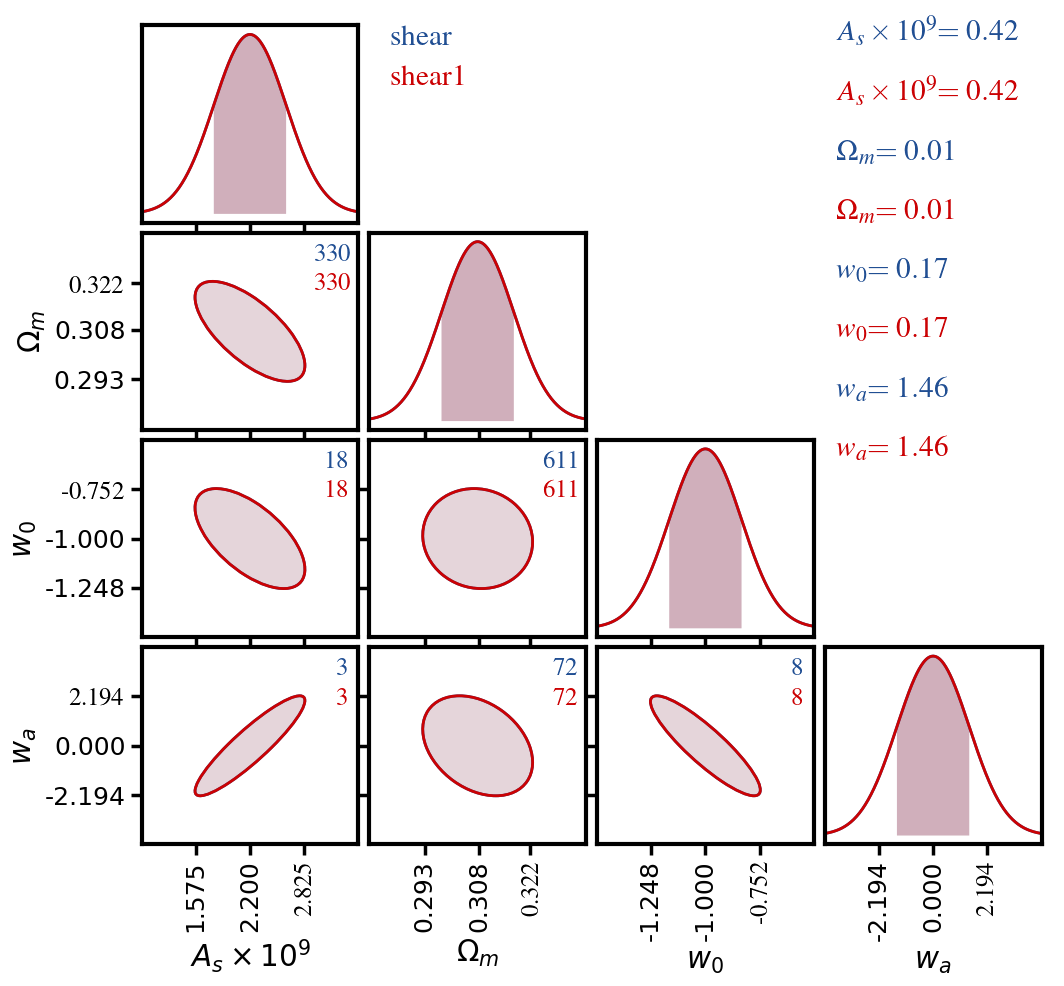

In [58]:
fish1 = fisher_tool(Fishers={0:f_allS1['cov_p_inv'],1:f_allS1['cov_p_inv']},pars={0:f_allS1['params_all'],1:f_allS1['params_all']},par_cen=cosmo_fid#{'Om':0.28374511,'Ase9':0.80351633}
                    ,fisher_titles={0:'shear',1:'shear1'})
f=fish1.plot_fish(pars=['Ase9','Om','w','wa'])

In [59]:
kappa_class,z_bins_kwargs=init_fish(n_source_bins=nbins,n_lens_bins=n_lens_bins,n_lensD_bins=n_lensD_bins,corrs=corrs,
                                          Win=WIN,store_win=store_win)
%time cl0G=kappa_class.cl_tomo(corrs=corrs,stack_corr_indxs=z_bins_kwargs['corr_indxs'])
lb=0.5*(l_bins[1:]+l_bins[:-1])
# cl0=cl0G['stack'].compute()

ns0:  27.0
ns0:  10.0
1 1 1
2 2 1
3 3 1
4 4 1
1 1 1
2 2 1
1 1 1
[(0, 0), (0, 1), (0, 2), (1, 1), (1, 2), (2, 2)]


./cov_utils.py:62: RuntimeWarning: invalid value encountered in true_divide
  Win0=2*jn(1,l_th)/l_th
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


cl dict done
CPU times: user 44.2 s, sys: 600 ms, total: 44.8 s
Wall time: 39.6 s


In [ ]:
cl_L=None
if cl_L is None:
    %time cl_L=cl0G['stack'].compute()

distributed.comm.inproc - WARNING - Closing dangling queue in <InProc local=inproc://136.152.250.183/16073/10 remote=inproc://136.152.250.183/16073/1>
distributed.comm.inproc - WARNING - Closing dangling queue in <InProc local=inproc://136.152.250.183/16073/11 remote=inproc://136.152.250.183/16073/1>
distributed.comm.inproc - WARNING - Closing dangling queue in <InProc local=inproc://136.152.250.183/16073/12 remote=inproc://136.152.250.183/16073/1>
distributed.comm.inproc - WARNING - Closing dangling queue in <InProc local=inproc://136.152.250.183/16073/13 remote=inproc://136.152.250.183/16073/1>
distributed.comm.inproc - WARNING - Closing dangling queue in <InProc local=inproc://136.152.250.183/16073/14 remote=inproc://136.152.250.183/16073/1>
distributed.comm.inproc - WARNING - Closing dangling queue in <InProc local=inproc://136.152.250.183/16073/15 remote=inproc://136.152.250.183/16073/1>
distributed.comm.inproc - WARNING - Closing dangling queue in <InProc local=inproc://136.152.2

In [ ]:
pz_params=['pz_b_s_{j}'.format(j=i) for i in np.arange(kappa_class.z_bins['shear']['n_bins'])]
# pz_params+=['pz_b_l_{j}'.format(j=i) for i in np.arange(2)]
galaxy_params=[]#['g_b_s_1{j}'.format(j=i) for i in np.arange(kappa_class.z_bins['shear']['n_bins'])]
# galaxy_params=['g_b_l_1{j}'.format(j=i) for i in np.arange(4)]

cosmo_params=np.atleast_1d(['As'])#,'Om','w','wa'])

%time f0=fisher_calc(cosmo_params=cosmo_params,z_params=pz_params,galaxy_params=galaxy_params,kappa_class=kappa_class,clS=cl_L,z_bins_kwargs=z_bins_kwargs,priors=priors)a